# Timeseries analysis of a CSV file in Python and Pandas

## Introduction and setup

More content like this can be found at [robotsquirrelproductions.com](https://robotsquirrelproductions.com/)

The lines below document the version of python used in this example

In [1]:
import sys
print(sys.version)

3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]


Import the libraries we need

In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta
import numpy as np

## Import the file metadata

Define the filename

In [3]:
str_filename = 'test_001_000.csv'

Open the file and instantiate the csv reader

In [4]:
fh = open(str_filename)
csv_reader = csv.reader(fh)

Read in the header labels

In [5]:
csv_header = next(csv_reader)
csv_header

['X', 'CH1', 'CH2']

Read in the dates, first as a string, then convert to a `datetime`

In [6]:
lst_dt_csv = next(csv_reader)
lst_dt_csv

['Date and Time',
 '2021-12-09 05:36:10.782-08:00',
 '2021-12-09 05:36:10.782-08:00']

In [7]:
dt_csv = np.array(list(map(datetime.fromisoformat, lst_dt_csv[1:3])))
dt_csv

array([datetime.datetime(2021, 12, 9, 5, 36, 10, 782000, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=57600))),
       datetime.datetime(2021, 12, 9, 5, 36, 10, 782000, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=57600)))],
      dtype=object)

Read in the sampling frequency

In [8]:
lst_fs = next(csv_reader)
np_d_fs = np.array(list(map(float, lst_fs[1:3])))
np_d_fs

array([1305.625068, 1305.625068])

Close the file

In [9]:
fh.close()

## Construct the dataframe

Read in the data frame

In [10]:
df_sig = pd.read_csv(str_filename, header=None, skiprows=5, names=csv_header)
df_sig

,X,CH1,CH2
0,0,0.05,-0.024
1,1,0.02,0.048
2,2,0.02,-0.008
3,3,0.06,0.064
4,4,0.02,0.136
...,...,...,...
1195,1195,-0.01,-0.112
1196,1196,0.00,-0.024
1197,1197,0.04,-0.080
1198,1198,-0.01,-0.008


## Plot the dataframe data

Display the signal in channel 1

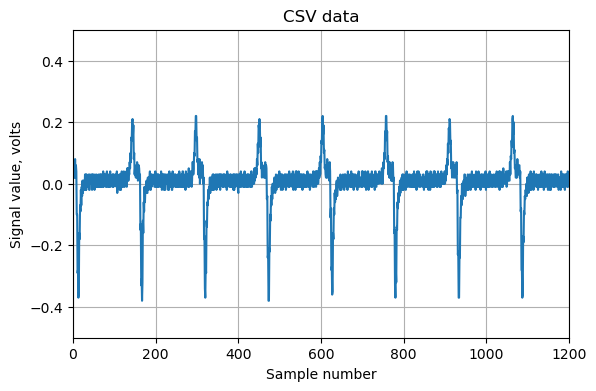

In [11]:
df_sig.CH1.plot()
plt.xlabel('Sample number')
plt.xlim([0, 1200])
plt.ylabel('Signal value, volts')
plt.ylim([-0.5, 0.5])
plt.title('CSV data')
plt.grid()


figure = plt.gcf()
figure.set_size_inches(4*1.6, 4)
plt.savefig('CSV Visualization.pdf')

## Add elapsed time series to the Pandas dataframe

In this section we add another column with the elapsed time in seconds. This will be helpful for plotting and future analysis.

Begin by constructing a numpy array with elapsed time in seconds from the number of samples and adding  that to our dataframe. This example assumes the sampling rate is the same for both series.

In [12]:
ns = len(df_sig.index)

We make an assumption about the sampling rates so add an assert to throw a flag if the assumption proves false. Python stores the sampling frequency as floats so a '==' does not always work. In this example the assert looks for very little difference betwen the two values.

In [13]:
assert abs(np_d_fs[0] - np_d_fs[1]) < 1e-15, 'The sampling frequency (fs) must be the same for both data series'

Finally, add the elapsed time to the dataframe

In [14]:
df_sig['elap_time'] = np.linspace(0,(ns-1),ns)/np_d_fs[0]

## Plot the elapsed time data

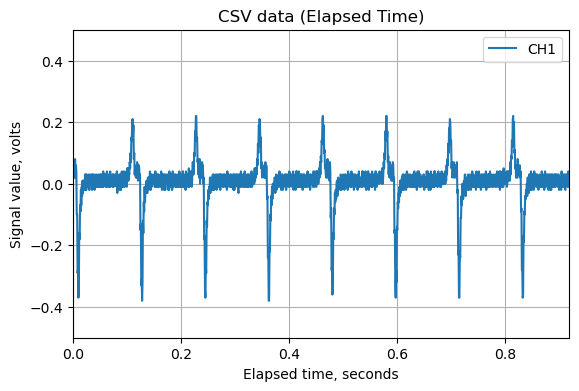

In [15]:
df_sig.plot('elap_time', 'CH1')
plt.xlabel('Elapsed time, seconds')
plt.xlim([min(df_sig.elap_time), max(df_sig.elap_time)])
plt.ylabel('Signal value, volts')
plt.ylim([-0.5, 0.5])
plt.title('CSV data (Elapsed Time)')
plt.grid()


figure = plt.gcf()
figure.set_size_inches(4*1.6, 4)
plt.savefig('CSV Visualization_ElapsedTime.pdf')

## Add a time stamp to the Pandas dataframe

This section uses the elapsed time and datetime values to add a timeseries to the data structure. This replaces sample number as the index for the dataframe. 

This section assumes the datetimes are the same and checks with an assertion (similar to above)

In [16]:
assert dt_csv[0] == dt_csv[1], 'Both datetime stamps must be the same'

Create a local lambda function to add the elapsed time in seconds to the base time stamp

In [17]:
add_secs = lambda np_sec: [dt_csv[0] + timedelta(seconds=d_sec) for d_sec in np_sec]

Add the datetime list to the dataframe

In [18]:
df_sig['dt']=add_secs(df_sig['elap_time'].to_numpy(dtype=float) )

Change the index to our newly created dt series

In [19]:
df_sig = df_sig.set_index('dt')

A quick sanity check to be sure the dataframe looks as we expect

In [20]:
df_sig.head()

,X,CH1,CH2,elap_time
dt,,,,
2021-12-09 05:36:10.782000-08:00,0,0.05,-0.024,0.000000
2021-12-09 05:36:10.782766-08:00,1,0.02,0.048,0.000766
2021-12-09 05:36:10.783532-08:00,2,0.02,-0.008,0.001532
2021-12-09 05:36:10.784298-08:00,3,0.06,0.064,0.002298
2021-12-09 05:36:10.785064-08:00,4,0.02,0.136,0.003064


Although not necessary, it can help to convert the dataframe times to local times for visualization

In [21]:
dt_local = df_sig.index.to_pydatetime()

## Plot the timeseries data

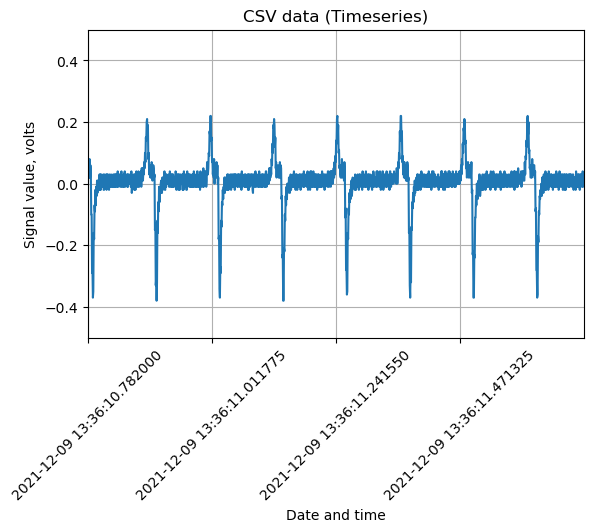

In [22]:
plt.plot(dt_local, df_sig['CH1'])

# This changes the formatter.
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m-%d %H:%M:%S.%f"))

plt.xlabel('Date and time')
plt.xlim([min(dt_local), max(dt_local)])
plt.xticks(dt_local, rotation = 45)
plt.locator_params(axis='x', nbins = 4)

plt.ylabel('Signal value, volts')
plt.ylim([-0.5, 0.5])
plt.title('CSV data (Timeseries)')
plt.grid()


figure = plt.gcf()
figure.set_size_inches(4*1.6, 4)
plt.savefig('CSV Visualization_TimeSeries.pdf')